# CS146 Project 2: Discrete and multi-level models

Here is a data set of kelp plant counts near the coast. The coastal area was divided into 100 20 m × 20 m grid squares and the number of kelp was painstakingly counted in each grid square. Unfortunately, some of the grid squares were not counted.

Your task is to fit an appropriate discrete count model for this data set and to estimate the number of kelp in the missing cells.

Prior knowledge: We expect something like 0 to 2 kelp plants per square meter. Note: Each grid square has an area of 400 m².

## Instructions

1. Complete all the required tasks below. There are also some optional tasks for extra credit.
2. Create a Python notebook with all your code, results, and the interpretation of your results. This Python notebook is your main deliverable for the assignment.
3. Keep it professional! Imagine you are writing your code and text for a client. You will be graded accordingly.

## Data

The integer values below are the recorded kelp counts. There are some `nan` values where we have missing data. The missing data show up as white squares in the plot below.

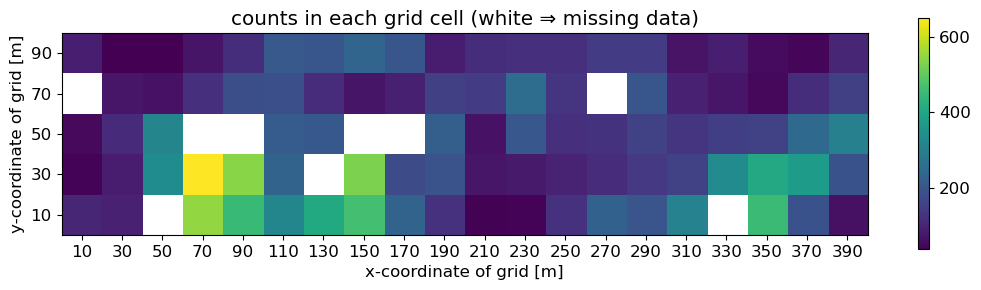

In [84]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import nan

plt.rcParams.update({'font.size': 12})

grid_count_x = 20  # number of grid cells in the x and y directions
grid_count_y = 5
grid_cell_width = 20  # number of meters per grid cell side
area_per_cell = grid_cell_width ** 2  # each grid cell has an area of (20 m)² = 400 m²

grid_x = (np.arange(grid_count_x) + 0.5) * grid_cell_width
grid_y = (np.arange(grid_count_y) + 0.5) * grid_cell_width

data = np.array([
    [101,  92, nan, 550, 450, 318, 408, 465, 232, 123,  39,  41, 123, 226, 198, 307, nan, 454, 191,  63],
    [ 43,  86, 334, 649, 540, 231, nan, 529, 179, 193,  74,  80,  94, 113, 138, 155, 331, 405, 372, 191],
    [ 51, 110, 314, nan, nan, 215, 205, nan, nan, 221,  67, 203, 120, 125, 158, 129, 149, 156, 245, 304],
    [nan,  74,  66, 119, 184, 186, 115,  71,  89, 151, 145, 255, 127, nan, 199,  92,  74,  49, 116, 153],
    [ 87,  36,  37,  70, 116, 207, 201, 235, 199,  84, 117, 118, 121, 144, 146,  69,  87,  54,  44, 101]])

plt.figure(figsize=(13, 3))
plt.title('counts in each grid cell (white ⇒ missing data)')
plt.xlabel('x-coordinate of grid [m]')
plt.ylabel('y-coordinate of grid [m]')
plt.imshow(data, origin='lower')
plt.xticks(np.arange(data.shape[1]), np.array(grid_x, dtype=int))
plt.yticks(np.arange(data.shape[0]), np.array(grid_y, dtype=int))
plt.colorbar()
plt.show()

## Importing All Necessary Libraries

In [85]:
import pymc as pm
import arviz as az
import scipy.stats as sts
import matplotlib.pyplot as plt
import numpy as np
import random
from copy import deepcopy

## Required tasks

1. Come up with a strategy for estimating the values of the missing cells. How can you use the cell values you have to estimate/predict the values of the cells you don’t have? Describe your strategy to the client.
2. Implement two Poisson models to produce the predictions for the missing cells.
  1. Complete pooling. Assume the counts are generated i.i.d. from a Poisson distribution with an unknown rate parameter. Compute the posterior distribution over the rate parameter and make predictions using this posterior distribution.
  2. Partial pooling. Assume a hierarchical/multi-level model where each grid cell has a Poisson distribution with its own rate parater but the rate parameters come from a common prior with unknown parameters. Choose the prior appropriately. Compute the posterior distribution over all the rate parameters and the parameters of your chosen prior and make predictions using this posterior distribution.
3. Explain or demonstrate how you came up with your prior distributions for the two models.
4. Show the predictions of the values of each missing cell. Explain the differences between the predictions of the complete pooling and partial pooling models. You will find that one model is more confident (has less variance in its predictions) than the other model. Explain which model we should prefer.

## Strategy

In order for us to make suitable estimations for the values of tehmissing cells, I can make use of two things: our prior information regarding this scenario and the data from the other grid cells that I possess. I can utilize these two factors to make a dsitrbution that will tell us about the Kelp count in any given cell.

Firstly, I needed to choose a suitable distribution that will model our data well, this is also called the likelihood distribution. In this case as I was dealing with finding the number of Kelps in a particualr cell a **Poisson distribution** will be well suited as it will allow me to find the probability of a given number of events. This particular distribution is also discrete making it suitable for the count predictions that I am are trying to make.

However, in order to use this distribution I need the parameter value $\lambda$ which is just the average rate of events. In order to decide a suitable value for this parameter I utilized the prior distribution, which in this case should have values that are restricted to positve numbers as Poisson distribution cannot take a negative values, as its parameter. This leaves us with a bunch of distributions we can use to get this $\lambda$ values, from which I choose **exponential distribution**.

Using our prior knoweldge about the scenario, I was able to get the parameter value for our prior distributions. From the information provided, I know we can expect to find 0-2 Kelps per square meter and each of the grid cell is said to be $400m^2$. So in order to get a good approxiamtion of Kelps per $m^2$ I took the average value of 1. As I have already selected our prior distribution, exponential distribution, I can just plug it in to get us our first prior. Thus giving us:
$$\lambda (m^2) \sim Exponential(1)$$

However, I also need to take the prior over a whole cell which is $400m^2$ so I could multiply our previous $\lambda$ value that I got for one cell with 400. Thus our prior will be: 
$$\lambda (cell) \sim Deterministic(4*\lambda (m^2))$$
(When plotting and analyzing lambda value from here on out I will just use the $\lambda (cell)$ value but will refer to it as lambda to keep things simple)

Now, I can use the prior distribution and the likelihood distribution in order to find the posterior distribution over the parameter value of $\lambda$.

The posterior distribution that I have computed will be able to represent a true picture or at least a better picture of the world as it has been informed by the data that was provided. Now, I can can use the new informed parameter values for $\lambda$ to get samples from the Poisson distrbution and make suitable predictions or estimates for the values that the grid is missing.


In [119]:
flattened_data = data.flatten()# flattens the data into a one-dimensional array

filtered_data = flattened_data[np.logical_not(np.isnan(flattened_data))]# removes all the missing values from the data

## Complete Pooling

As seen from the heading the first model will be based on Complete Pooling which basically means that the count values for the Kelps come from the use of the same singualr prior value.

These are the distributiosn we will be looking at:

**Prior:**
$$\lambda (m^2) \sim Exponential(1)$$
$$\lambda (cell) \sim Deterministic(400*\lambda (m^2))$$
**Likelihood:**
$$X_{i} \sim Poisson(\lambda (cell))$$
Let the coding begin!

#### Our Model

In [87]:
# Creating the complete pooling model

with pm.Model() as complete_pool:
    
    #prior
    lambda_m2 = pm.Exponential('lambda_m2', lam=1)
    lambda_cell = pm.Deterministic('lambda_cell', lambda_m2*400)
    
    #likelihood
    X = pm.Poisson('X', lambda_cell, observed=filtered_data)
    
    prior_predictive_complete = pm.sample_prior_predictive()
    
    inference_complete = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda_m2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 83 seconds.


#### Prior Predictive Distrbution

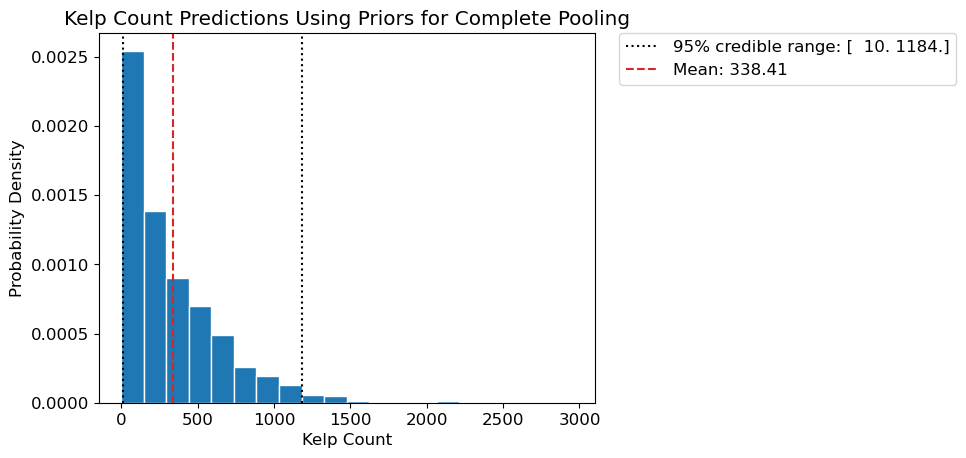

In [118]:
prior_predicted_data = prior_predictive_complete.prior_predictive.X.values.flatten()
data_mean = np.mean(prior_predicted_data)
data_range = np.quantile(prior_predicted_data, (0.025, 0.975))
plt.hist(prior_predicted_data, bins=20, edgecolor='white', density=True)
plt.axvline(data_range[0], color='black', linestyle=':', label=f'95% credible range: {np.round(data_range, 2)}')
plt.axvline(data_range[1], color='black', linestyle=':')
plt.axvline(data_mean, color='C3', linestyle='--', label=f'Mean: {np.round(data_mean, 2)}')
plt.xlabel('Kelp Count')
plt.ylabel('Probability Density')
plt.title('Kelp Count Predictions Using Priors for Complete Pooling')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

It looks like our prior-predictive distrbution seems to be good as it is able to cover all the values that can potetnially be in our data as this distrbution basically covers all the possible positive values even if they are with a minisucle probability, the 95% credible range foes from 10 to 1184, thus it is able to take into consideration the uncertainity of having high Kelp count values.

#### Sampler's Performance

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lambda_m2,0.45,0.00,0.45,0.46,0.00,0.00,1702.31,2827.48,1.0
lambda_cell,180.54,1.39,178.08,183.31,0.03,0.02,1702.31,2827.48,1.0


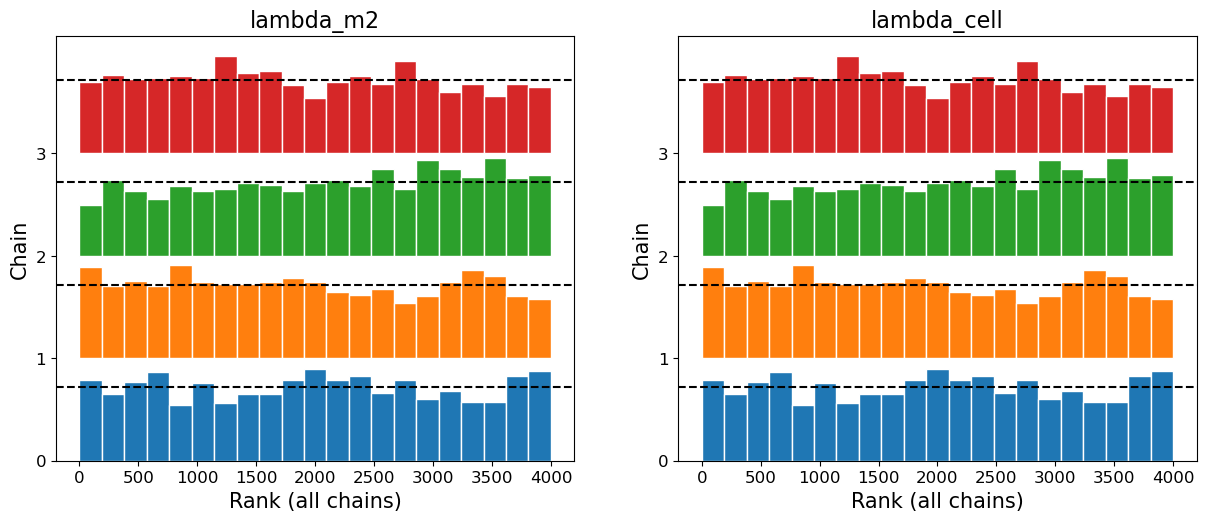

In [89]:
az.plot_rank(inference_complete)
az.summary(inference_complete, round_to=2)

array([[<AxesSubplot:title={'center':'lambda_m2'}>,
        <AxesSubplot:title={'center':'lambda_m2'}>],
       [<AxesSubplot:title={'center':'lambda_cell'}>,
        <AxesSubplot:title={'center':'lambda_cell'}>]], dtype=object)

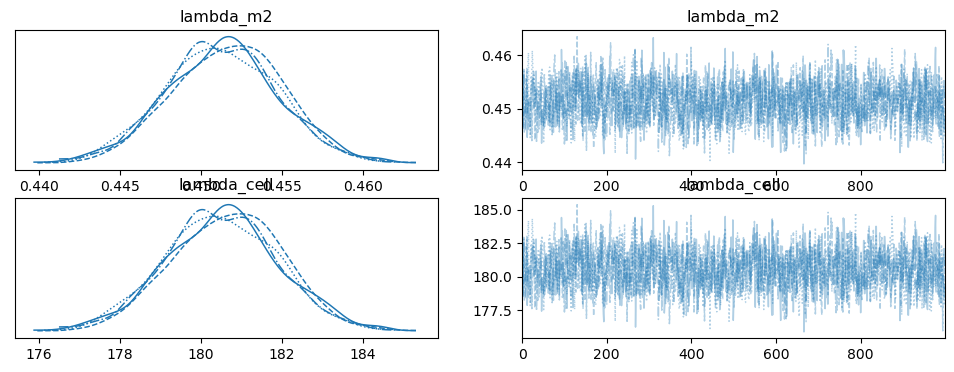

In [90]:
az.plot_trace(inference_complete)

We can see from the sumary table, the rank plots, and the trace plot that the sampler is working well. Looking at the summary table we see that the $\hat{r}$ value is 1 which is good. We can also see that the ESS values are at least 10% of the sample size which again means sampling is good. Looking at the distributions for the chains in the rank plot we can see that they are fairly normal which is also an indication of good sampling. From the trace plot we can see that the sampler chains are converging well, the left plot, and sampling is randomly done, right plot.

Thus, our model is good to go for further computation.

#### Posterior and Posterior Predictvie Distributions

In [91]:
with complete_pool:
    posterior_complete = inference_complete.posterior.lambda_cell.values.flatten()
    inference_posterior_predictive_complete = pm.sample_posterior_predictive(inference_complete)

posterior_predictive_complete = inference_posterior_predictive_complete.posterior_predictive.X.values.flatten()

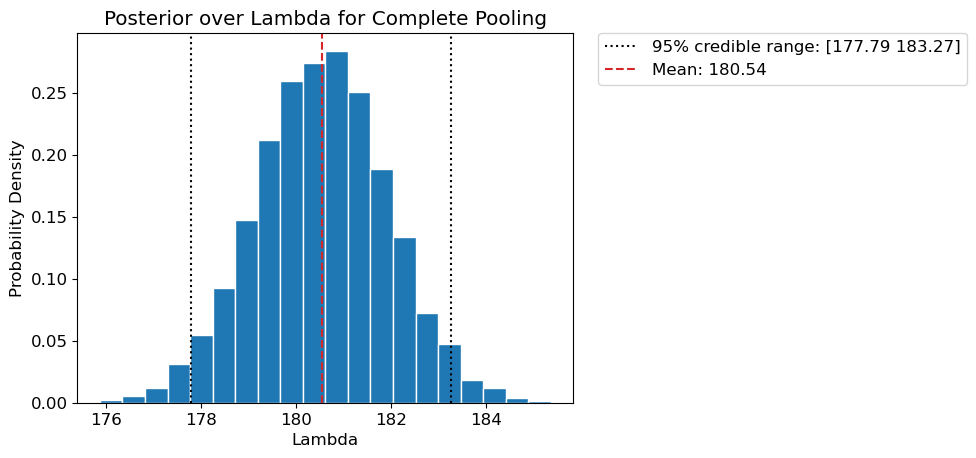

In [117]:
data_mean = np.mean(posterior_complete)
data_std = np.std(posterior_complete)
data_range = np.quantile(posterior_complete, (0.025, 0.975))
# print(f'Mean of posterior over lambda for complete pooling (2 d.p.): {np.round(data_mean, 2)}')
# print(f'Standard Deviation of posterior over lambda for complete pooling (2 d.p.): {np.round(data_std, 2)}')
# print(f'95% quantile range of posterior over lambda for complete pooling (2 d.p.): {np.round(data_range, 2)}')
plt.hist(posterior_complete, bins=20, edgecolor='white', density=True)
plt.axvline(data_range[0], color='black', linestyle=':', label=f'95% credible range: {np.round(data_range, 2)}')
plt.axvline(data_range[1], color='black', linestyle=':')
plt.axvline(data_mean, color='C3', linestyle='--', label=f'Mean: {np.round(data_mean, 2)}')
plt.xlabel('Lambda')
plt.ylabel('Probability Density')
plt.title('Posterior over Lambda for Complete Pooling')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

We can see from the distrbution above that the mean for this distribution is around 180.54, which would basically mean that we expect to see the Kelp count to be centered around this value since this $\lambda$ parameter defines the average rate for our Poisson Distribution.

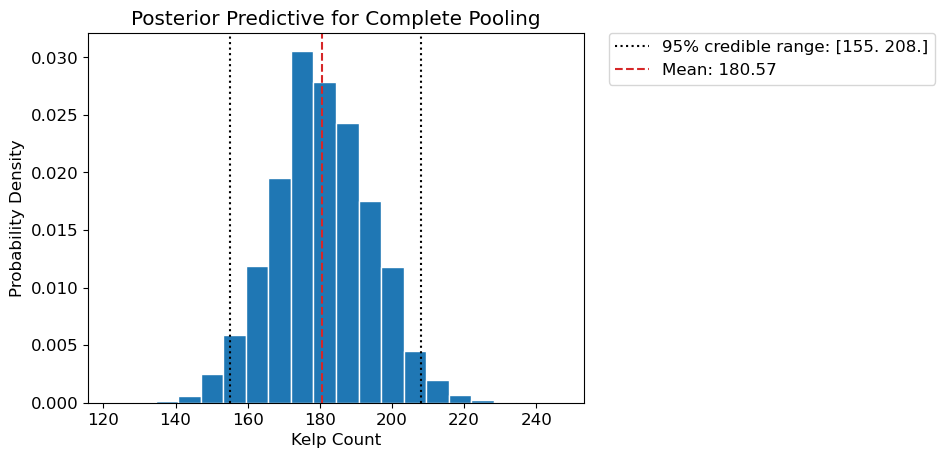

In [116]:
data_mean = np.mean(posterior_predictive_complete)
data_std = np.std(posterior_predictive_complete)
data_range = np.quantile(posterior_predictive_complete, (0.025, 0.975))
#print(f'Mean of posterior predictive: {np.round(data_mean, 2)}')
# print(f'Standard Deviation of posterior predictive: {np.round(data_std, 2)}')
#print(f'95% quantile range of posterior predictive: {np.round(data_range, 2)}')
plt.hist(posterior_predictive_complete, bins= 20, edgecolor='white', density=True)
plt.axvline(data_range[0], color='black', linestyle=':', label=f'95% credible range: {np.round(data_range, 2)}')
plt.axvline(data_range[1], color='black', linestyle=':')
plt.axvline(data_mean, color='C3', linestyle='--', label=f'Mean: {np.round(data_mean, 2)}')
plt.xlabel('Kelp Count')
plt.ylabel('Probability Density')
plt.title('Posterior Predictive for Complete Pooling')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

Looking at the posterior predictive distribution above we can see that the mean is around 180.57. By looking at the quantile range we know that most of the values for our count wil lie in between 155 and 208 with a 95% confidence as it is our credible interval. This model is presenting us with the distribution of our Kelp counts that we expect every grid cell to have.

## Partial Pooling

#### Our Model

Now we are looking at partial pooling. To summarize, partial pooling is a heirarchical model in which we have different prior values for $\lambda$ for each cell, or unit of data. In order to generate these different $\lambda$ values we need to provide an hyper-prior which is informed collectively by the whole population data, which in this case is the whole grid. This ensures that cells wouldn't be idenitcal and thus may or may not have the same representation as another cell. I used a Log Normal Hyper prior as it constraints the value to be just positve and its parameters, $\mu$ and $\sigma$ are defined so that the values we get from this distribution are mainlky restricted to the values I think are suitable for putting into the exponential distrbution, meaning they are close to 1.

We utilized the same prior and likelihood distributions from Complete pooling in order to main consistency and ensure that the comparison between these two models is fair. 

**Hyper-Prior**
$$\lambda \sim LogNormal(\mu=0, \sigma=0.25)$$
**Prior:**
$$\lambda (m^2)_i \sim Exponential(\lambda)$$
$$\lambda (cell)_i \sim Deterministic(400*\lambda (m^2)_i)$$
**Likelihood:**
$$X_{i} \sim Poisson(\lambda (cell)_i)$$
Let the coding begin!

In [94]:
with pm.Model() as partial_pool:
    #hyper-prior
    L = pm.LogNormal('L', mu=0,sigma=0.25)
    
    lambda_m2 = pm.Exponential('lambda_m2', lam=L, shape=len(filtered_data))
    lambda_cell = pm.Deterministic('lambda_cell', 400*lambda_m2)
    
    X = pm.Poisson('X', mu = lambda_cell, observed = filtered_data)
    
    prior_predictive_partial = pm.sample_prior_predictive()
    
    inference_partial = pm.sample()
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [L, lambda_m2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 62 seconds.


#### Prior Predictive Distrbution

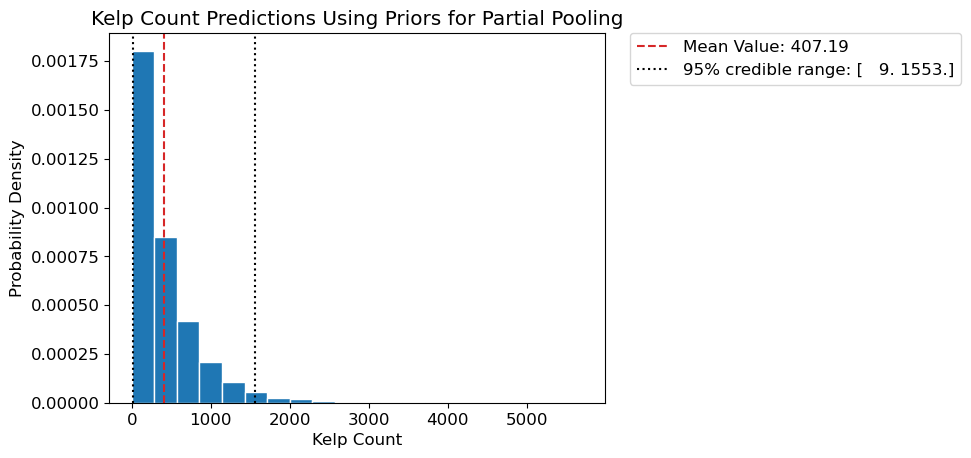

In [114]:
prior_predicted_data = prior_predictive_partial.prior_predictive.X.values.flatten()

data_mean = np.mean(prior_predicted_data)
data_range = np.quantile(prior_predicted_data, (0.025, 0.975))

plt.hist(prior_predicted_data, bins=20, edgecolor='white', density=True)
plt.axvline(data_mean, color='C3', linestyle='--', label=f'Mean Value: {np.round(data_mean, 2)}')
plt.axvline(data_range[0], color='black', label=f'95% credible range: {np.round(data_range, 2)}', linestyle=':')
plt.axvline(data_range[1], color='black', linestyle=':')
plt.xlabel('Kelp Count')
plt.ylabel('Probability Density')
plt.title('Kelp Count Predictions Using Priors for Partial Pooling')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

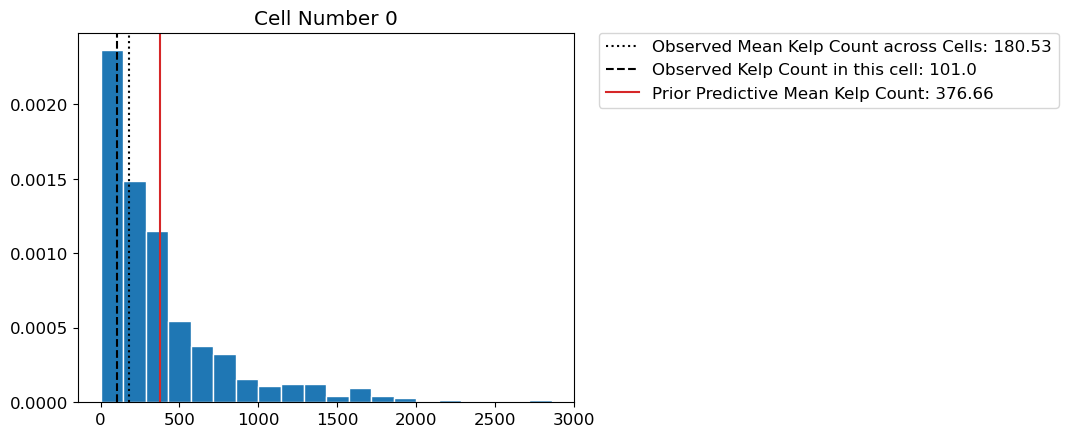

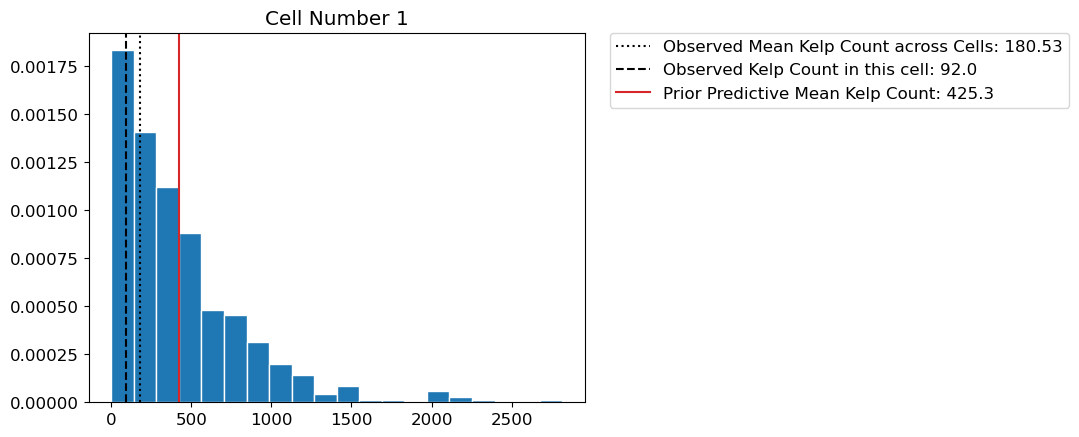

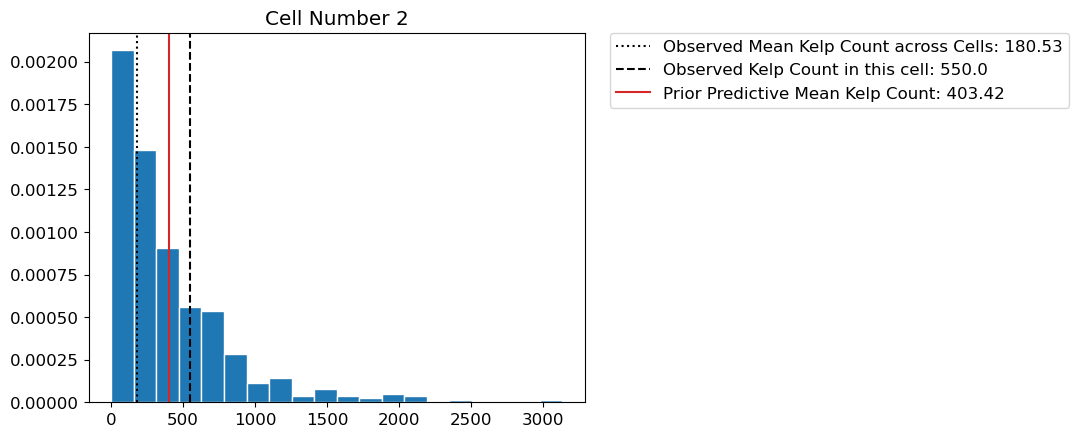

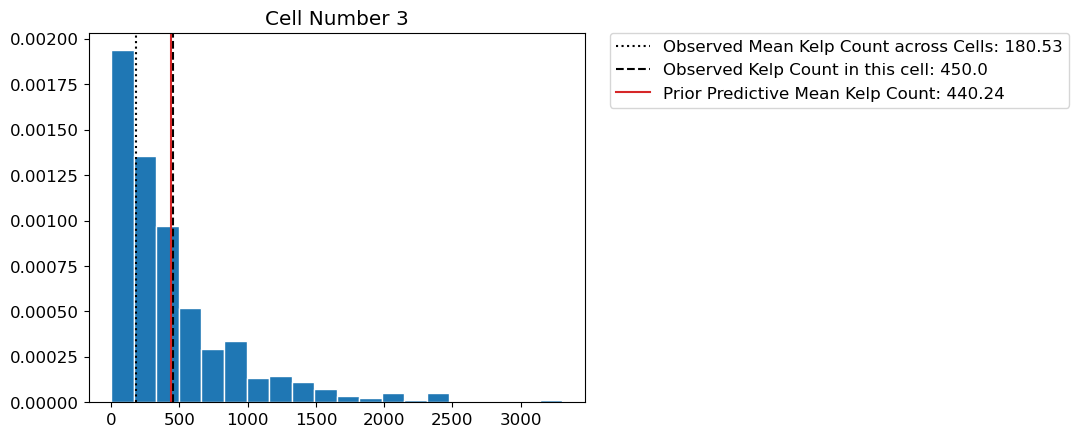

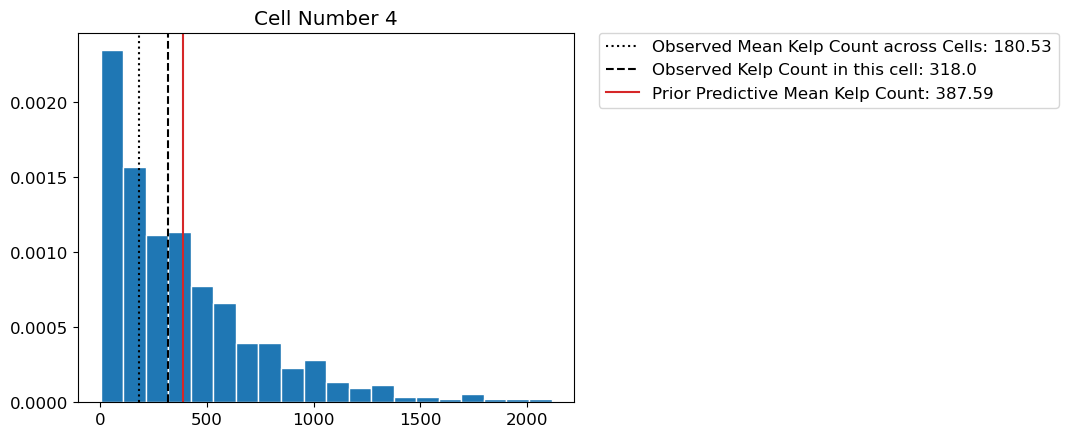

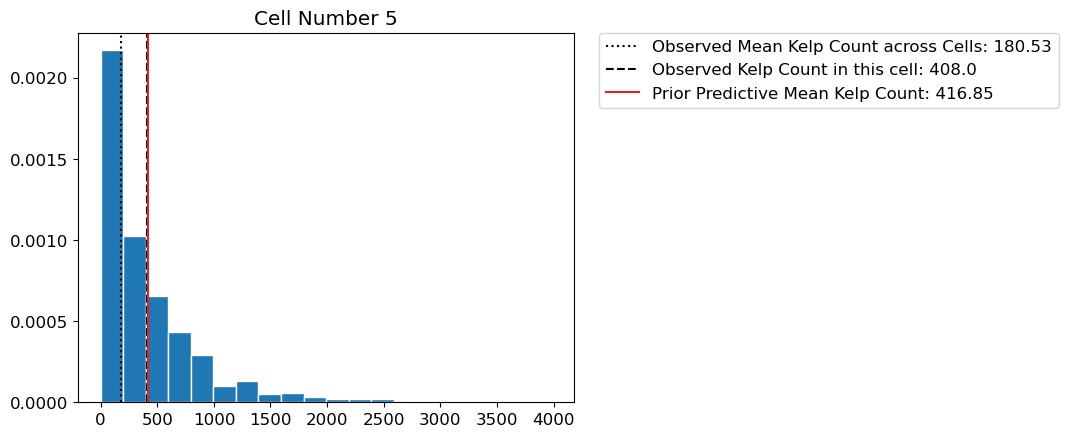

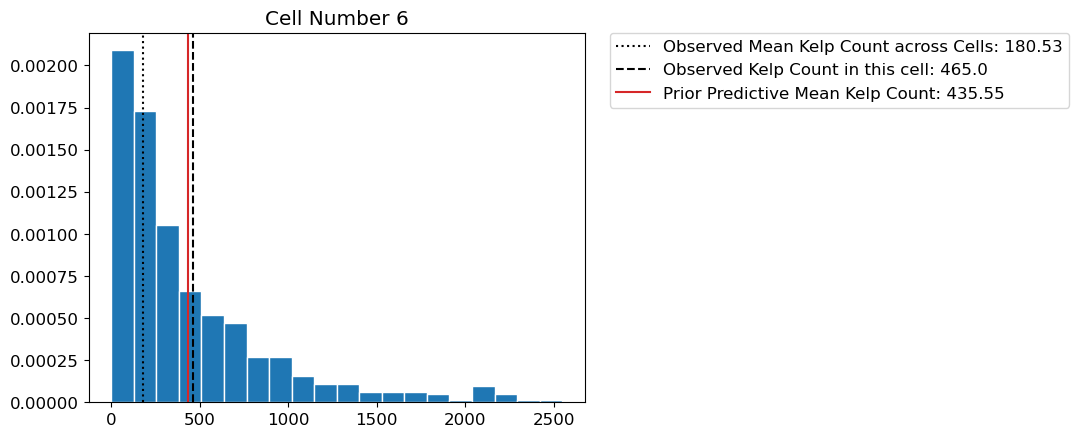

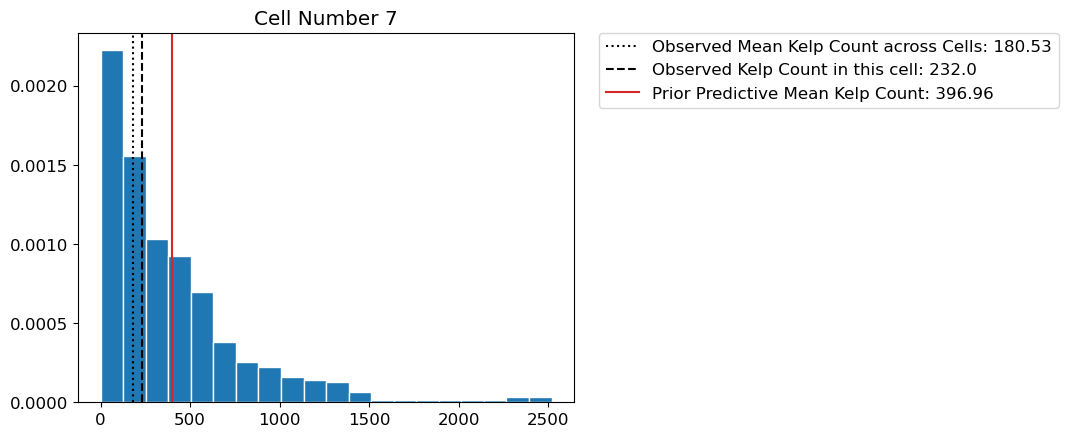

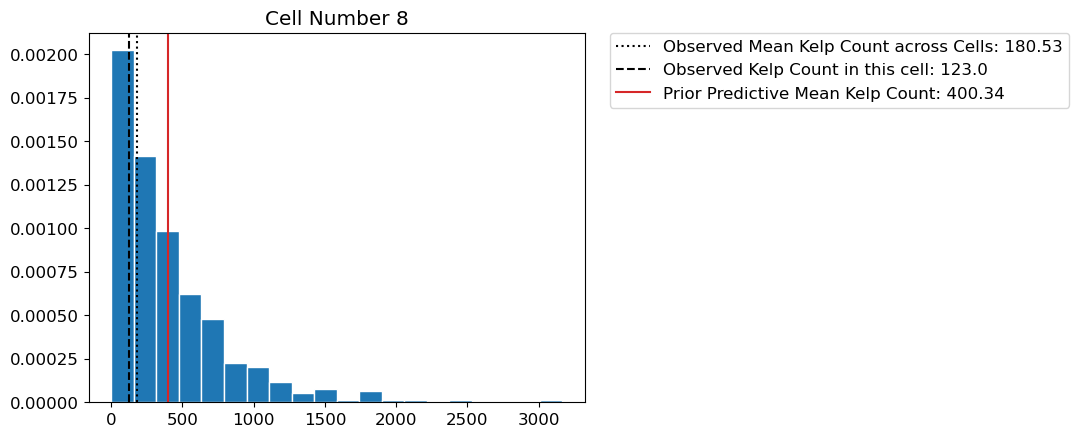

In [96]:
# Combine the chains and draws in each chain into an array of samples.
prior = prior_predictive_partial.prior_predictive.stack(sample=('chain', 'draw')).transpose('sample', ...)
cell_indexes = [i for i in range(9)]  # Adjust this to see however many cells you like
for cell_index in cell_indexes:
    plt.figure()
    plt.title(f'Cell Number {cell_index}')
    # Plot a histogram of the prior predictive samples of X for this cell
    plt.hist(prior.X.values[:, cell_index], color='C0', bins=20, density=True, edgecolor='white')

    # Plot a vertical line to show the mean Kelp Count for this cell and across all cells
    plt.axvline(filtered_data.mean(), color='black', linestyle=':', 
                label=f'Observed Mean Kelp Count across Cells: {np.round(filtered_data.mean(), 2)}')
    plt.axvline(filtered_data[cell_index], color='black', linestyle='--', 
                label=f'Observed Kelp Count in this cell: {np.round(filtered_data[cell_index], 2)}')

    # Plot a vertical line to show the mean prior predictive for Kelp count.
    plt.axvline(prior.X.values[:, cell_index].mean(), color='C3', linestyle='-', 
                label=f'Prior Predictive Mean Kelp Count: {np.round(prior.X.values[:, cell_index].mean(), 2)}')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.show()

We can see that our prior predictive distribution is working well as it is able to cover all the values that we think our data can possess as it is able to cover all positve values, with the probability diminishing as we go further along the x-axis but never reaching zero. This allows the prior to cover extreme values which are unlikely but can potentialy be found in our data.

We can also see from the separate prior values for each cell that as our model has not taken into account the data we have and is purely taking samples through the model we have defined all the cells even individually possess a simillar prior predictive distribution which means that the prior predictive distribution is working well.

#### Samplers Performance

In [97]:
az.summary(inference_partial)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
L,1.954,0.202,1.585,2.347,0.002,0.002,7108.0,2584.0,1.0
lambda_m2[0],0.254,0.025,0.205,0.299,0.000,0.000,8421.0,2656.0,1.0
lambda_m2[1],0.231,0.024,0.187,0.276,0.000,0.000,8265.0,2716.0,1.0
lambda_m2[2],1.371,0.059,1.261,1.480,0.001,0.000,7222.0,3046.0,1.0
lambda_m2[3],1.122,0.053,1.026,1.223,0.001,0.000,8040.0,3251.0,1.0
...,...,...,...,...,...,...,...,...,...
lambda_cell[86],69.621,8.153,54.650,84.914,0.090,0.064,8111.0,2757.0,1.0
lambda_cell[87],87.695,9.157,71.435,105.885,0.112,0.080,6742.0,3088.0,1.0
lambda_cell[88],54.828,7.207,41.817,68.819,0.077,0.056,8890.0,3128.0,1.0
lambda_cell[89],44.761,6.692,32.842,57.830,0.076,0.055,7921.0,2822.0,1.0


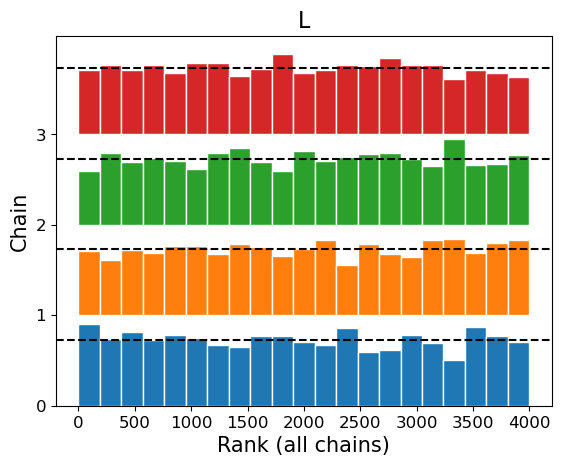

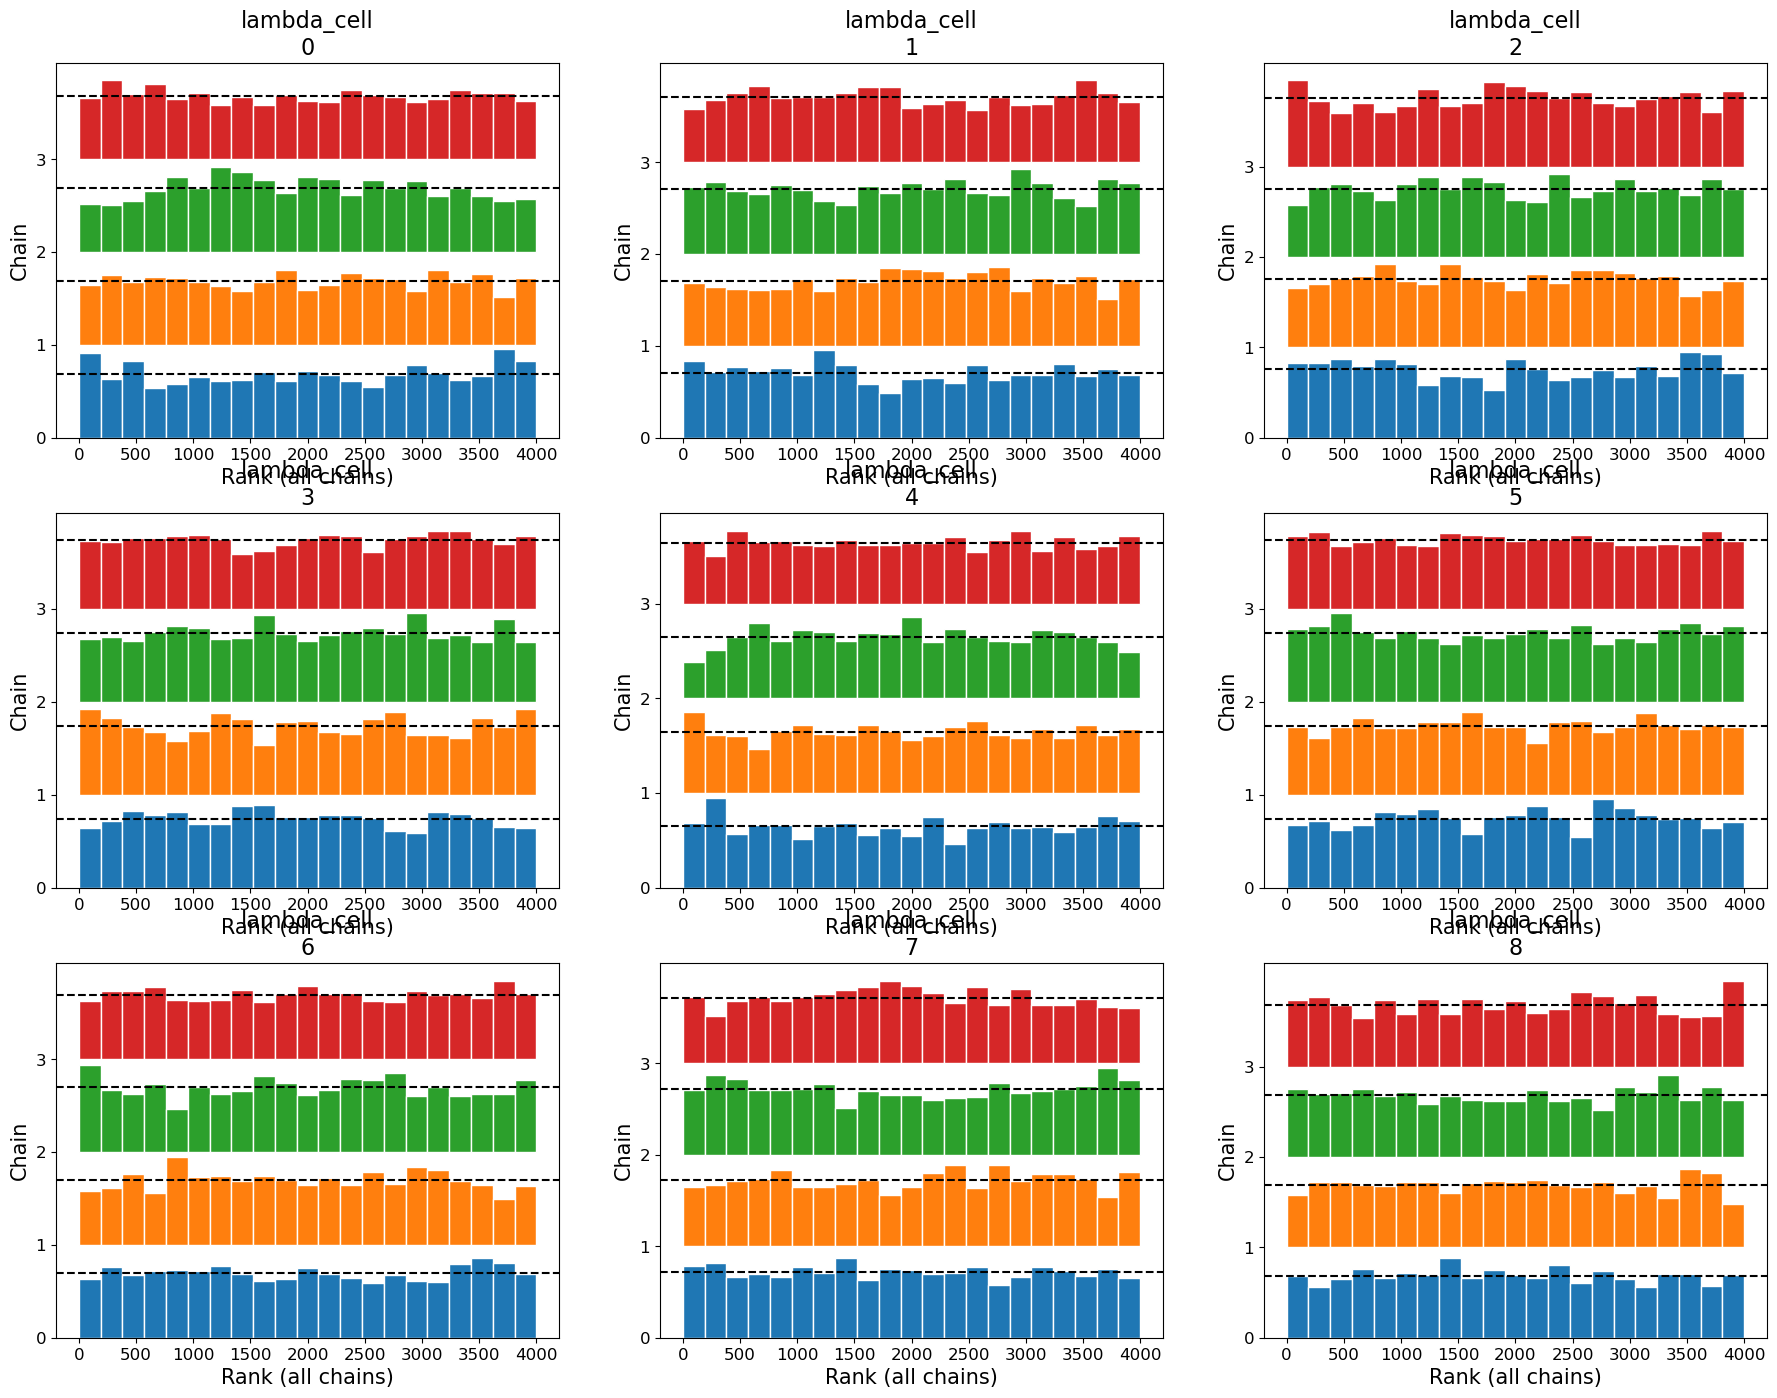

In [98]:
az.plot_rank(inference_partial, var_names = ['L'])
# Only first 9 displayed as it wil be pointless to plot all 91 histograms 
#and this can provide us with a general outlook for our sampler
az.plot_rank(inference_partial.posterior.lambda_cell[:,:,:9])
plt.show()

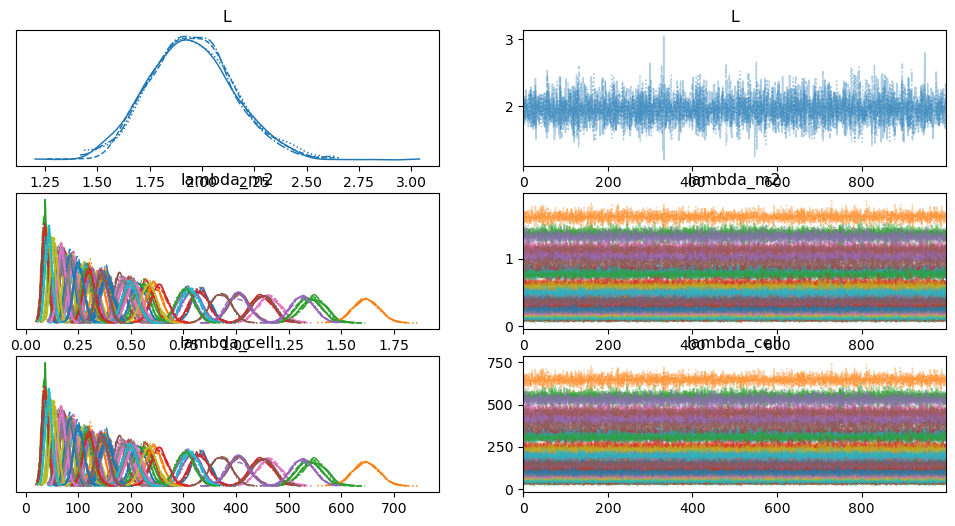

In [99]:
az.plot_trace(inference_partial)
plt.show()

Again we can see that the sampler is working well. From the summary table we can see that the $\hat{r}$ values and the ESS values are within suitable range. From the rank plots we can see that they are uniformly distributed. Finaslly from the trace plot we can analyze that the chains are converging well and the sampling is random.

#### Posterior and Posterior Predictive Distrbutions

In [100]:
with partial_pool:
    posterior_partial_hyper_prior = inference_partial.posterior.L.values.flatten()
    posterior_partial_lambda = inference_partial.posterior.lambda_cell.values.flatten()
    inference_posterior_predictive_partial = pm.sample_posterior_predictive(inference_partial)

posterior_predictive_partial = inference_posterior_predictive_partial.posterior_predictive.X.values.flatten()

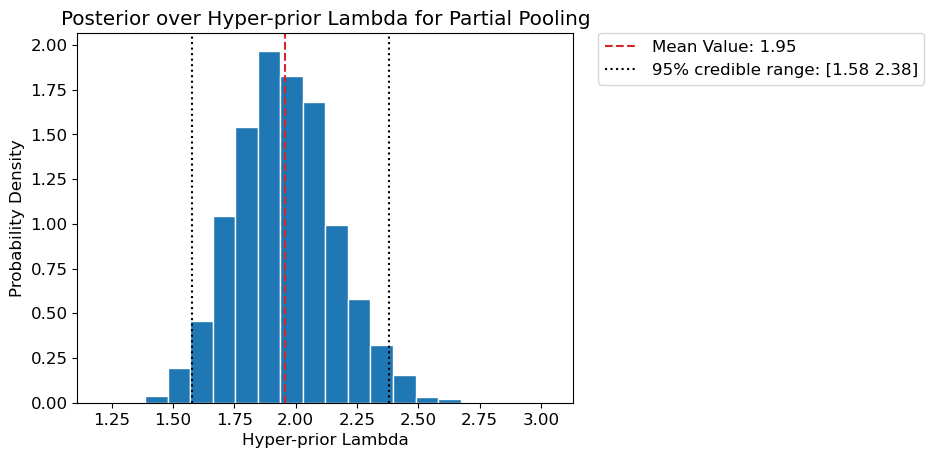

In [111]:
data_mean = np.mean(posterior_partial_hyper_prior)
data_range = np.quantile(posterior_partial_hyper_prior, (0.025, 0.975))

plt.hist(posterior_partial_hyper_prior, bins=20, edgecolor='white', density=True)
plt.axvline(data_mean, color='C3', linestyle='--', label=f'Mean Value: {np.round(data_mean, 2)}')
plt.axvline(data_range[0], color='black', label=f'95% credible range: {np.round(data_range, 2)}', linestyle=':')
plt.axvline(data_range[1], color='black', linestyle=':')
plt.xlabel('Hyper-prior Lambda')
plt.ylabel('Probability Density')
plt.title('Posterior over Hyper-prior Lambda for Partial Pooling')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

We can see that the general shape of the histogram above is simillar to the posterior we plotted over $\lambda$ for the complete pooling above. This can be the case as both of these distributions have pre-defined parameters based on our prior knowledge.

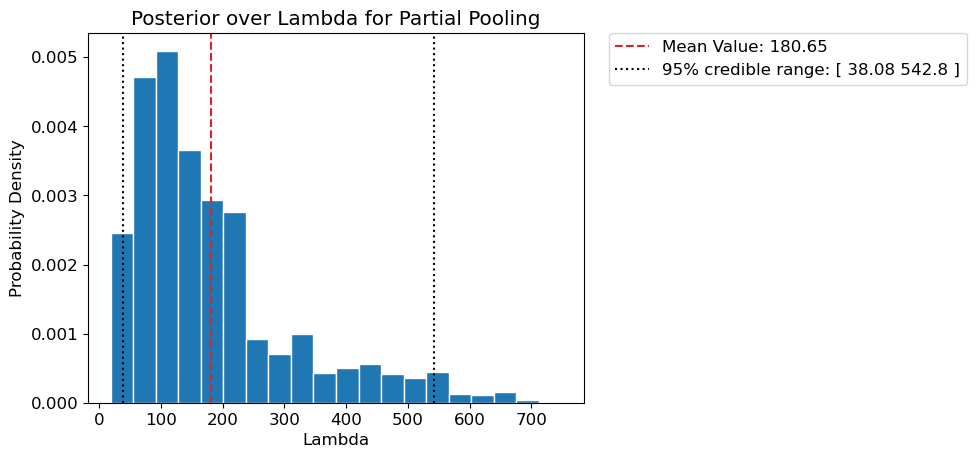

In [112]:
data_mean = np.mean(posterior_partial_lambda)
data_range = np.quantile(posterior_partial_lambda, (0.025, 0.975))

plt.hist(posterior_partial_lambda, bins=20, edgecolor='white', density=True)
plt.axvline(data_mean, color='C3', linestyle='--', label=f'Mean Value: {np.round(data_mean, 2)}')
plt.axvline(data_range[0], color='black', label=f'95% credible range: {np.round(data_range, 2)}', linestyle=':')
plt.axvline(data_range[1], color='black', linestyle=':')
plt.xlabel('Lambda')
plt.ylabel('Probability Density')
plt.title('Posterior over Lambda for Partial Pooling')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

We can see from the plot and the legend that the $\lambda$ values are more spread out this time. This is the case because each individual cell is having the opportunity to have its own parameters. This will make our predictions fall on a wider range.

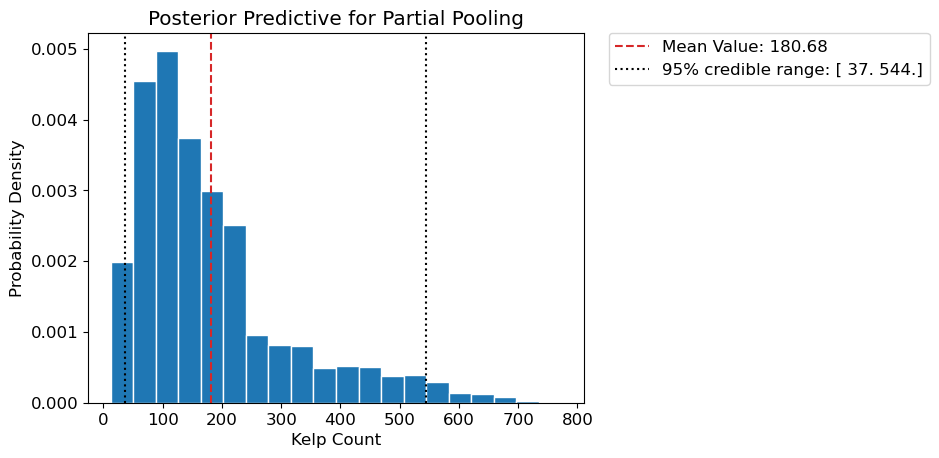

In [113]:
data_mean = np.mean(posterior_predictive_partial)
data_range = np.quantile(posterior_predictive_partial, (0.025, 0.975))

plt.hist(posterior_predictive_partial, bins= 20, edgecolor='white', density=True)
plt.axvline(data_mean, color='C3', linestyle='--', label=f'Mean Value: {np.round(data_mean, 2)}')
plt.axvline(data_range[0], color='black', label=f'95% credible range: {np.round(data_range, 2)}', linestyle=':')
plt.axvline(data_range[1], color='black', linestyle=':')
plt.xlabel('Kelp Count')
plt.ylabel('Probability Density')
plt.title('Posterior Predictive for Partial Pooling')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

Looking at the posterior predictive distribution above we can see that the mean is around 180.68. By looking at the quantile range we know that most of the values for our count wil lie in between 37 and 544 with a 95% confidence as it is our credible interval. This range is way bigger as compared to our complete pooling and the reasoning for this has been mention in the descripotion for posterior over lambda for partial pooling above. This model is presenting us with the distribution of our Kelp counts that we expect every grid cell to have. However, we can notice something interesting if we plot posterior predictive of each cell seprately.

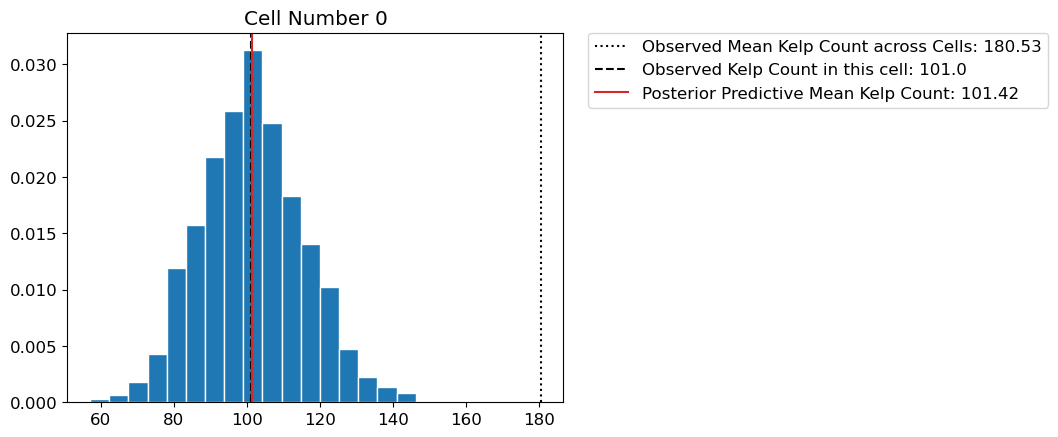

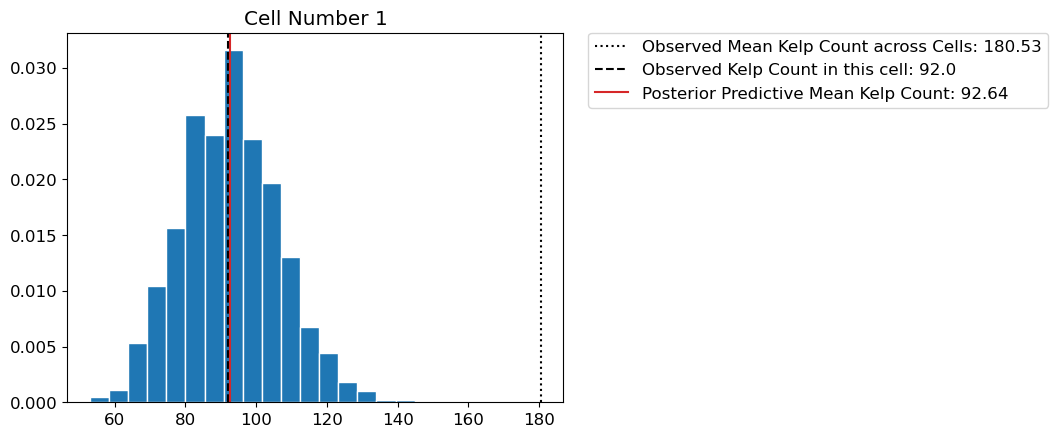

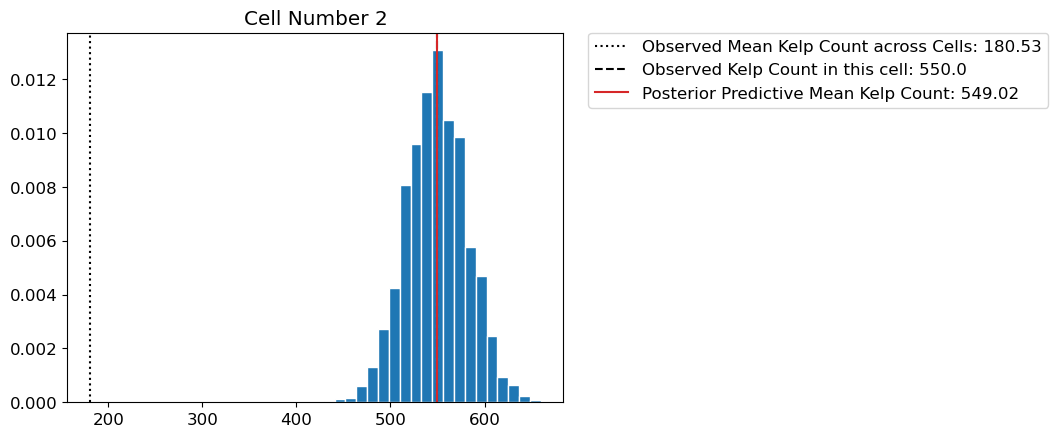

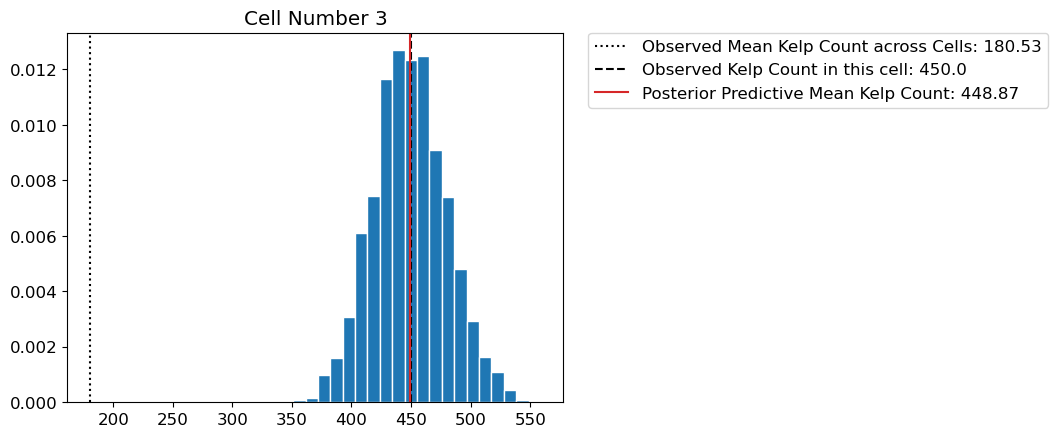

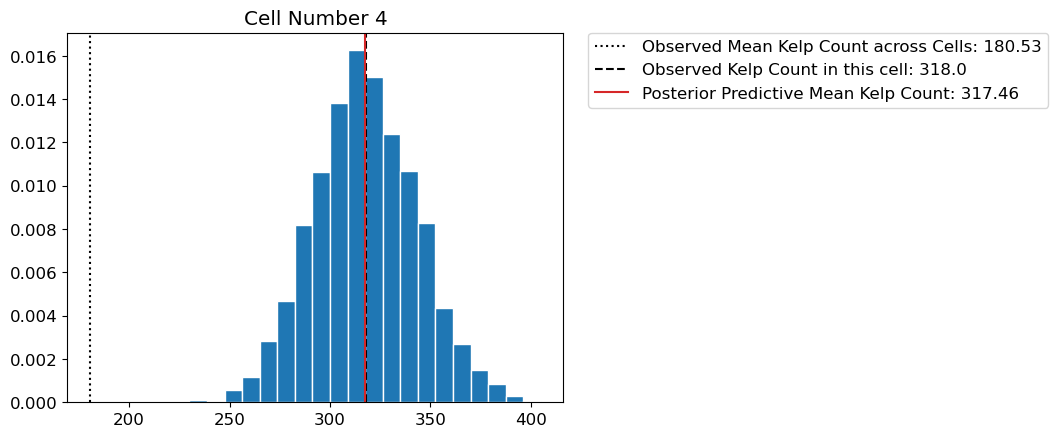

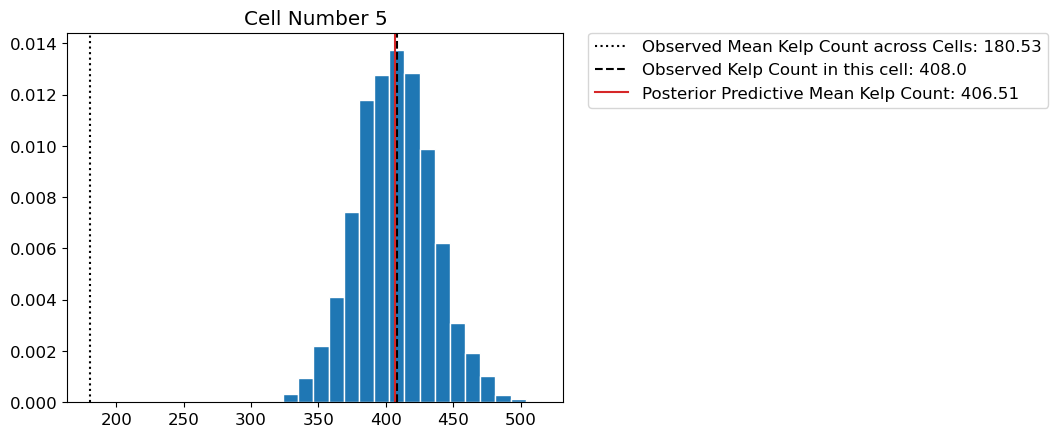

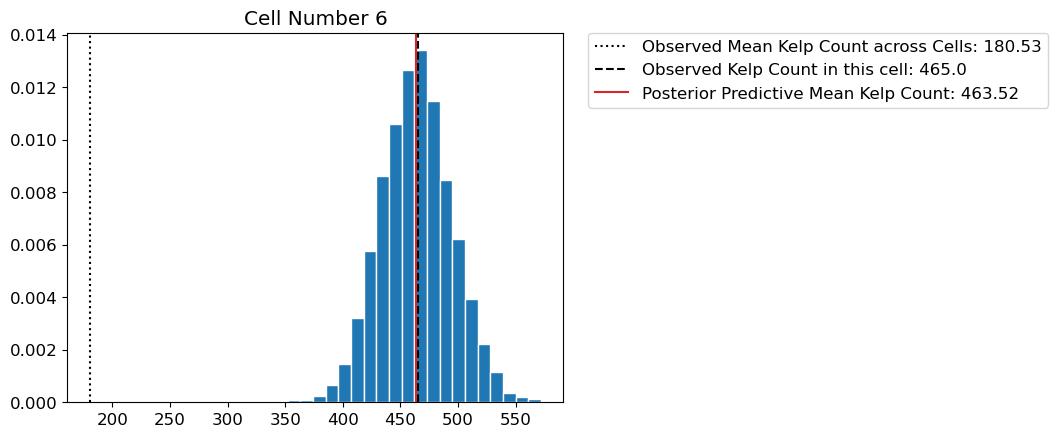

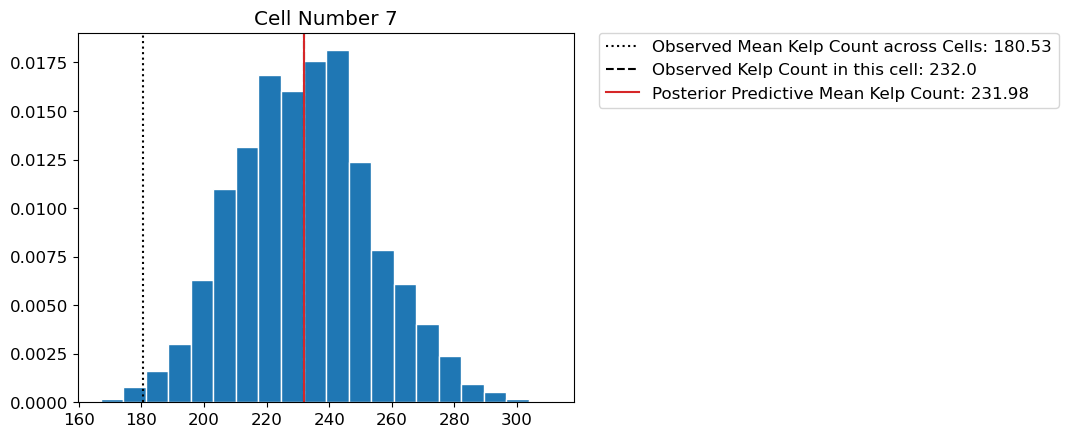

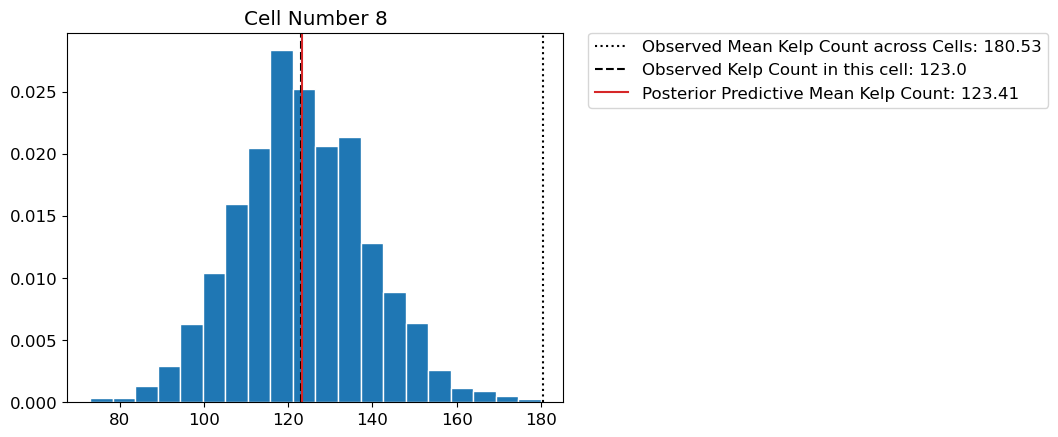

In [104]:
 # Combine the chains and draws in each chain into an array of samples.
post = inference_posterior_predictive_partial.posterior_predictive.stack(sample=('chain', 'draw')).transpose('sample', ...)
cell_indexes = [i for i in range(9)]  # Adjust this to see however many cells you like
for cell_index in cell_indexes:
    plt.figure()
    plt.title(f'Cell Number {cell_index}')
    # Plot a histogram of the prior predictive samples of X for this cell
    plt.hist(post.X.values[:, cell_index], color='C0', bins=20, density=True, edgecolor='white')

    # Plot a vertical line to show the mean Kelp Count for this cell and across all cells
    plt.axvline(filtered_data.mean(), color='black', linestyle=':', 
                label=f'Observed Mean Kelp Count across Cells: {np.round(filtered_data.mean(), 2)}')
    plt.axvline(filtered_data[cell_index], color='black', linestyle='--', 
                label=f'Observed Kelp Count in this cell: {np.round(filtered_data[cell_index], 2)}')

    # Plot a vertical line to show the mean prior predictive for Kelp count.
    plt.axvline(post.X.values[:, cell_index].mean(), color='C3', linestyle='-', 
                label=f'Posterior Predictive Mean Kelp Count: {np.round(post.X.values[:, cell_index].mean(), 2)}')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.show()

Looking at the histograms we see that all the cells have a different distributions as comapred to each other. This is because of how partial pooling functions as all the different cells recieve different parameter values. I only plotted the first 9 plots as plotting all 91 plots would just be overkill and useless. We can see from the plots above that posterior predictive mean kelp count and the actual Kelp count for that particular simillar showing it is able to capture the behaviour of individual cells well. We can also see that the observed mean kelp count always stays at the same value as it is informed by the overall grid insetad of one cell.

## Filling the blanks

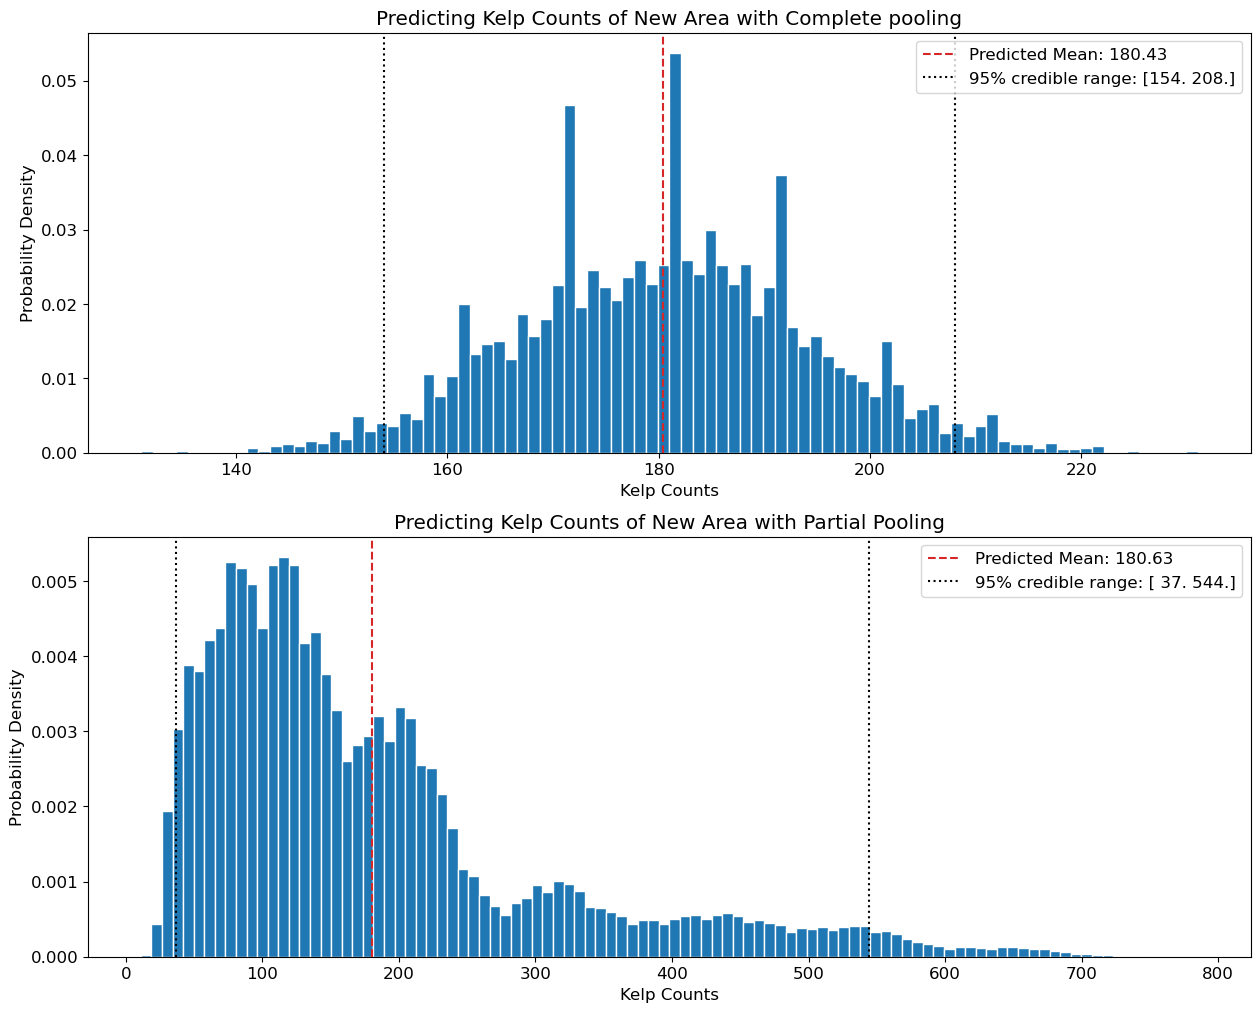

In [105]:
counts_complete = sts.poisson.rvs(mu = posterior_complete)
counts_partial = sts.poisson.rvs(mu = posterior_partial_lambda)

data_mean_c = np.mean(counts_complete)
data_range_c = np.quantile(counts_complete, (0.025, 0.975))
data_mean_p = np.mean(counts_partial)
data_range_p = np.quantile(counts_partial, (0.025, 0.975))

fig, [ax1, ax2] = plt.subplots(2, 1, figsize = (15, 12))

ax1.hist(counts_complete, color = 'C0', bins = 90, density = True, edgecolor = 'white')
ax1.axvline(data_mean_c, color='C3', linestyle='--', label=f'Predicted Mean: {np.round(data_mean_c, 2)}')
ax1.axvline(data_range_c[0], color = 'black', linestyle=':', label = f'95% credible range: {np.round(data_range_c, 2)}')
ax1.axvline(data_range_c[1], color = 'black', linestyle=':')
ax1.set_xlabel('Kelp Counts')
ax1.set_ylabel('Probability Density')
ax1.set_title("Predicting Kelp Counts of New Area with Complete pooling")
ax1.legend()

ax2.hist(counts_partial , color = 'C0', bins = 100, density = True, edgecolor = 'white')
ax2.axvline(data_mean_p, color='C3', linestyle='--', label=f'Predicted Mean: {np.round(data_mean_p, 2)}')
ax2.axvline(data_range_p[0], color = 'black', linestyle=':', label = f'95% credible range: {np.round(data_range_p, 2)}')
ax2.axvline(data_range_p[1], color = 'black', linestyle=':')
ax2.set_xlabel('Kelp Counts')
ax2.set_ylabel('Probability Density')
ax2.set_title("Predicting Kelp Counts of New Area with Partial Pooling")
ax2.legend()


plt.show()

The two histogram plots above show the distribution for the predicted Kelp counts for the new cells that are added to the grid. We can see that both distributions are significantly different as two different models were used to make it. 

First lets look at the complete pooling distribution. The complete pooling distribution is able to predict an approximately normal looking distribution, with an approximate mean value of 180.43, and the range of 95% creibility going from 154 to 208. This is a more compact distribution

Next, looking at the partial pooling distrbution we can see that the partial pooling distrbution is more right skewed but still possesses a higher mean value of approximately 180.63. Its 95% credible range goes from 37 to 544. Thus partial pooling is able to comapre a much wider range of values.

We can identify the reasonig for this difference in distrbution by simply undersatdning the idea behind these two pooling techniques. As discussed before complete pooling takes teh whole population's information to generate parameters which is why it is more centered and normal looking. On the other hand partial pooling takes into consideration each cell individually, thus any new cell will be assumed to be different and would not fall under a normal looking distrbution. The way partial pooling's distribution is shown, it would mean that it is more likely to choose from a low Kelps count value but it also has the capability of choosing a higher Kelp Count as it considers for the extreme values as well.

In [125]:
def finder(x, lst):
    #finding the missing index
    arr= []
    for i, row in enumerate(lst):
        for j, element in enumerate(row):
            if element == x:
                arr.append((i, j))
    return arr

missing_index = finder(True, np.isnan(data))
missing_index

[(0, 2), (0, 16), (1, 6), (2, 3), (2, 4), (2, 7), (2, 8), (3, 0), (3, 13)]

In [129]:
# Picking random samples from the complete and partial pooling distributions
data_complete = deepcopy(data)
data_partial = deepcopy(data)

complete_pooling_samples = random.sample(list(posterior_predictive_complete), 9)
partial_pooling_samples = random.sample(list(posterior_predictive_partial), 9)

data_complete[np.isnan(data_complete)] = complete_pooling_samples
data_partial[np.isnan(data_partial)] = partial_pooling_samples

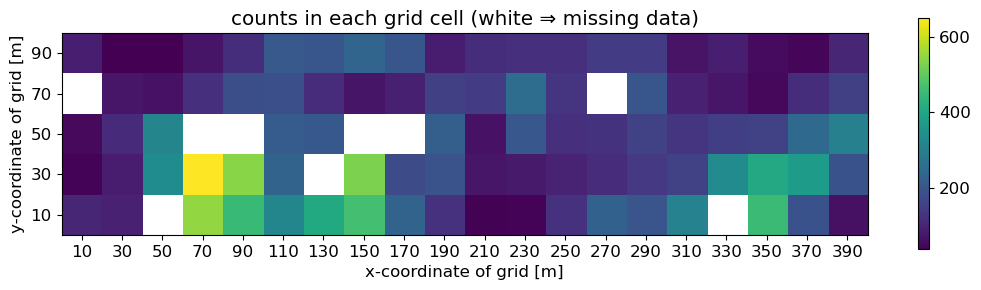

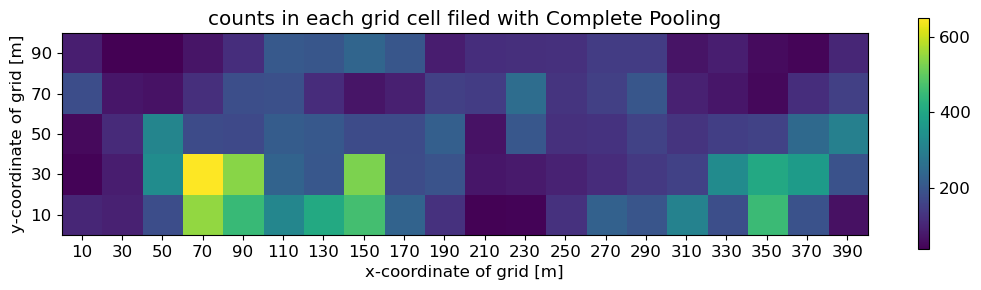

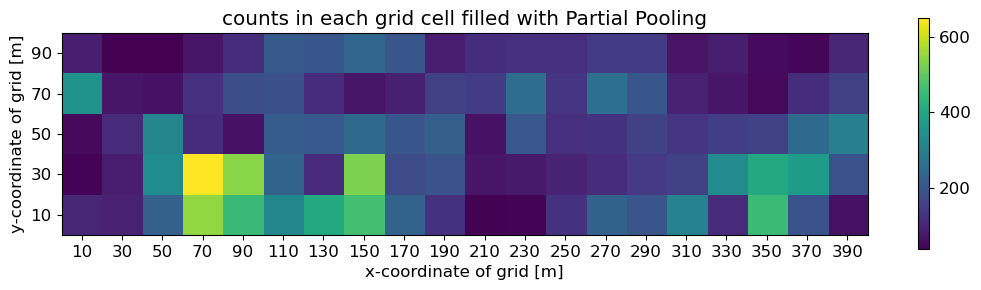

In [130]:
plt.rcParams.update({'font.size': 12})

grid_count_x = 20  # number of grid cells in the x and y directions
grid_count_y = 5
grid_cell_width = 20  # number of meters per grid cell side
area_per_cell = grid_cell_width ** 2  # each grid cell has an area of (20 m)² = 400 m²

grid_x = (np.arange(grid_count_x) + 0.5) * grid_cell_width
grid_y = (np.arange(grid_count_y) + 0.5) * grid_cell_width

plt.figure(figsize=(13, 3))
plt.title('counts in each grid cell (white ⇒ missing data)')
plt.xlabel('x-coordinate of grid [m]')
plt.ylabel('y-coordinate of grid [m]')
plt.imshow(data, origin='lower')
plt.xticks(np.arange(data.shape[1]), np.array(grid_x, dtype=int))
plt.yticks(np.arange(data.shape[0]), np.array(grid_y, dtype=int))
plt.colorbar()
plt.show()

plt.figure(figsize=(13, 3))
plt.title('counts in each grid cell filed with Complete Pooling')
plt.xlabel('x-coordinate of grid [m]')
plt.ylabel('y-coordinate of grid [m]')
plt.imshow(data_complete, origin='lower')
plt.xticks(np.arange(data_complete.shape[1]), np.array(grid_x, dtype=int))
plt.yticks(np.arange(data_complete.shape[0]), np.array(grid_y, dtype=int))
plt.colorbar()
plt.show()

plt.figure(figsize=(13, 3))
plt.title('counts in each grid cell filled with Partial Pooling')
plt.xlabel('x-coordinate of grid [m]')
plt.ylabel('y-coordinate of grid [m]')
plt.imshow(data_partial, origin='lower')
plt.xticks(np.arange(data_partial.shape[1]), np.array(grid_x, dtype=int))
plt.yticks(np.arange(data_partial.shape[0]), np.array(grid_y, dtype=int))
plt.colorbar()
plt.show()


The main cells we have to focus on here are (50, 10), (330, 10), (130, 30), (70, 50), (90, 50), (150, 50), (170, 50), (10, 70), and (270, 70). Looking at some cells like (70, 50), (130, 30), and (270, 70) we see partial pooling tends to go for a smaller Kelp count as comapred to the complete pooling. However, we still are not able to completely disect this distinction by just looking at the filled grid cells above. We are able to only partially tell the difference between the colors and thus in order to get the true differnce I have taken the values that each pooling technique has produced and printed them below.

Complete Pooling | Partial Pooling
181.0                   225.0
Complete Pooling | Partial Pooling
184.0                   109.0
Complete Pooling | Partial Pooling
203.0                   110.0
Complete Pooling | Partial Pooling
175.0                   114.0
Complete Pooling | Partial Pooling
171.0                   65.0
Complete Pooling | Partial Pooling
175.0                   247.0
Complete Pooling | Partial Pooling
175.0                   200.0
Complete Pooling | Partial Pooling
180.0                   350.0
Complete Pooling | Partial Pooling
153.0                   259.0


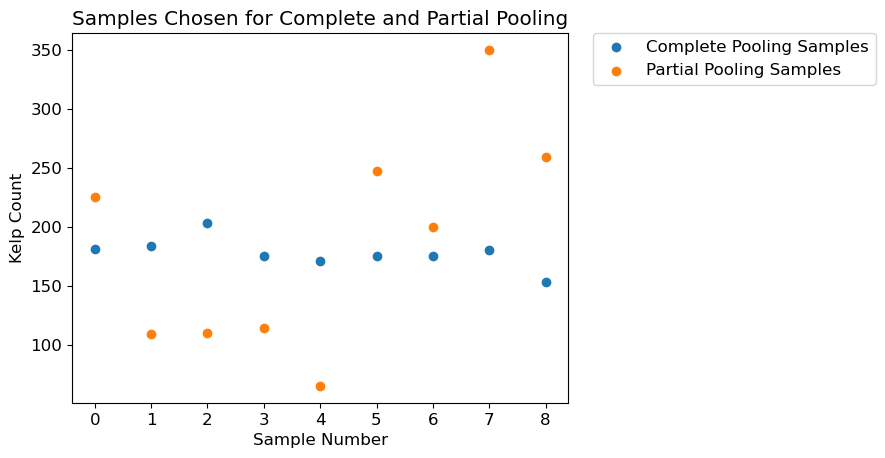

In [131]:
line_complete = []
line_partial = []

for i in range(len(missing_index)):
    print('Complete Pooling | Partial Pooling')
    print(f'{data_complete[missing_index[i]]}                   {data_partial[missing_index[i]]}')
    line_complete.append(data_complete[missing_index[i]])
    line_partial.append(data_partial[missing_index[i]])

x_range = [i for i in range(9)]
plt.scatter(x_range, line_complete, label='Complete Pooling Samples')
plt.scatter(x_range, line_partial, label='Partial Pooling Samples')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xlabel('Sample Number')
plt.ylabel('Kelp Count')
plt.title('Samples Chosen for Complete and Partial Pooling')
plt.show()


Now after looking at these values we can see that complete pooling tends to stay close to the mean. This will ensuure low variability and just gives us samples based on the overall look of the grid. This mdoel will not account for values far from the mean.

For partial pooling samples we can see that they are almost all over the place. These samples are not bound by the constraint of the population mean as complete pooling was and thus are able to sample for values that are way below the mean or way above the mean as well. These samples are based on the individual cells information instead of the whole popualtion adn thus we can see that there is no general pattern that these values follow.

In a nutshell, we see that partial pooling is able to capture the essence of variability in the grid pretty good when compared to complete pooling. Although complete pooling may look neat and tidy, I would say I would rather sue the partial pooling model as it is able to capture teh possibility fo extreme values and i my opinion its variability would more closely match the true nature of the grid as compared to complete pooling. Maybe I would have preffered complete pooling if the grid was way bigger as then we would have a rather better approximate of the average which most closely resembles even the individual cell, but partial pooling is my winner here.

## Optional stretch goals

We can do better than the two models above since it is likely that there is _spatial correlation_ between the cells. That is, we expect cells that are near each other to be correlated and cells that are far apart to be (mostly) uncorrelated. You can use any resources you want to learn about spatial models — [McElreath Chapter 14](https://learning-oreilly-com.ezproxy.sfpl.org/library/view/statistical-rethinking-2nd/9780429639142/xhtml/22_Chapter14.xhtml) is a good source.

Create _and explain_ a spatial Poisson model for this data set, fit the model and present your posteriors and predictions of the missing data to the client. Compare your results to the models above and explain which predictions seem better (and why).

Warning: Fitting spatial models can be _sloooow_. Expect to spend a lot of time (hours) fitting these models. It is highly recommended that you don’t use the full data set while you are setting up and debugging your model, to save time. Fit the model to the full data set once you are happy that everything works as it should.